<a href="https://colab.research.google.com/github/demolakstate/AdeNet-Deep-Learning-Architecture/blob/main/ResNet_101_early_stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Nov  1 23:00:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
ls

all_dataset_2.zip  sample_data/


In [ ]:
!unzip all_dataset_2.zip

Archive:  all_dataset_2.zip
   creating: all_dataset_2/
   creating: all_dataset_2/validation/
   creating: all_dataset_2/validation/damaged/
  inflating: all_dataset_2/validation/damaged/1777.JPG  
  inflating: all_dataset_2/validation/damaged/1656.JPG  
  inflating: all_dataset_2/validation/damaged/2702.JPG  
  inflating: all_dataset_2/validation/damaged/2680.JPG  
  inflating: all_dataset_2/validation/damaged/2669.JPG  
  inflating: all_dataset_2/validation/damaged/1051.JPG  
  inflating: all_dataset_2/validation/damaged/1172.JPG  
  inflating: all_dataset_2/validation/damaged/2692.JPG  
  inflating: all_dataset_2/validation/damaged/888.JPG  
  inflating: all_dataset_2/validation/damaged/4653.JPG  
  inflating: all_dataset_2/validation/damaged/1673.JPG  
  inflating: all_dataset_2/validation/damaged/1769.JPG  
  inflating: all_dataset_2/validation/damaged/4767.JPG  
  inflating: all_dataset_2/validation/damaged/4597.JPG  
  inflating: all_dataset_2/validation/damaged/1090.JPG  
  in

In [ ]:
#imports

import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet101,preprocess_input

#from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array,load_img

import numpy as np
from cv2 import resize
from os import path, listdir

In [ ]:
n_classes = 2

In [ ]:
#set up MobileNet GlobalMaxPooling and unsepcified input resolution

inputs = Input(shape=(None,None,3))
#net = MobileNetV2(include_top=False, alpha=0.35, weights='imagenet', input_tensor=inputs, classes=n_classes)

net = ResNet101(include_top=False, weights=None, input_tensor=inputs, classes=n_classes)

#net = NASNetLarge(include_top=False, weights='imagenet', input_tensor=inputs, classes=n_classes)
net = GlobalMaxPooling2D()(net.output)
outputs = Dense(n_classes,activation='softmax')(net)

model = Model(inputs=inputs,outputs=outputs)
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])


In [ ]:
#data generator class; yields batches of data for training/testing
class ImageGenerator():

    def __init__(self, directory, batch_size=16, shuffle=False, max_dimension=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_dimension = max_dimension
        
        self.image_paths = []
        self.class_labels = []
        
        #create list of image file paths and class target labels
        for class_label, class_dir in enumerate(listdir(directory)):
            self.image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]
            self.class_labels += [class_label for _ in listdir(path.join(directory,class_dir))]

        self.image_paths = np.array(self.image_paths)
        self.class_labels = np.array(self.class_labels)

        #index array for shuffling data
        self.idx = np.arange(len(self.image_paths))
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self,img_path):
        
        #load image from path and convert to array
        img = load_img(img_path, color_mode='rgb', interpolation='nearest')
        img = img_to_array(img)
        
        #downsample image if above allowed size if specified
        max_dim = max(img.shape) 
        if self.max_dimension:
            if max_dim > self.max_dimension:
                new_dim = tuple(d*self.max_dimension//max_dim for d in img.shape[1::-1])
                img = resize(img, new_dim)
            
        #scale image values
        img = preprocess_input(img)

        return img
    
    
    def _pad_images(self,img,shape):
        #pad images to match largest image in batch
        img = np.pad(img,(*[((shape[i]-img.shape[i])//2,
                    ((shape[i]-img.shape[i])//2) + ((shape[i]-img.shape[i])%2)) for i in range(2)],
                          (0,0)),mode='constant',constant_values=0.)
        
        return img


    def __call__(self):
        #shuffle index
        if self.shuffle:
            np.random.shuffle(self.idx)
        
        #generate batches
        for batch in range(len(self)):

            batch_image_paths = self.image_paths[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]
            batch_class_labels = self.class_labels[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]

            batch_images = [self._load_image(image_path) for image_path in batch_image_paths]

            max_resolution = tuple(max([img.shape[i] for img in batch_images]) for i in range(2))
            batch_images = np.array([self._pad_images(image,max_resolution) for image in batch_images])

            yield batch_images, batch_class_labels

In [ ]:
#model.load_weights('insulators-v33.h5')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
#initialize our generators; specifying data directories, batch size, and dimension threshold

train_image_directory = 'all_dataset_2/train'
test_image_directory = 'all_dataset_2/validation'

n_classes = 10
batch_size = 4
max_dimension = 512

#create generators for training and generating

train_generator = ImageGenerator(train_image_directory, batch_size=batch_size, shuffle=True, max_dimension=max_dimension)
test_generator = ImageGenerator(test_image_directory, batch_size=batch_size, max_dimension=max_dimension)

#convert generators into tf.data.Dataset objects for optimization with keras model fit method

train_dataset = tf.data.Dataset.from_generator(train_generator,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))

test_dataset = tf.data.Dataset.from_generator(test_generator,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))


#train and evaluate model
history = model.fit(train_dataset,validation_data=test_dataset,epochs=100,verbose=1,workers=2,max_queue_size=20, callbacks=[callback])

Epoch 1/100
851/851 [==============================] - 534s 628ms/step - loss: 2.1173 - sparse_categorical_accuracy: 0.6111 - val_loss: 17.1718 - val_sparse_categorical_accuracy: 0.5488
Epoch 2/100
851/851 [==============================] - 313s 368ms/step - loss: 1.4742 - sparse_categorical_accuracy: 0.5879 - val_loss: 17.3033 - val_sparse_categorical_accuracy: 0.4924
Epoch 3/100
851/851 [==============================] - 255s 300ms/step - loss: 1.1627 - sparse_categorical_accuracy: 0.5952 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.5734
Epoch 4/100
851/851 [==============================] - 234s 275ms/step - loss: 1.1763 - sparse_categorical_accuracy: 0.6061 - val_loss: 0.6571 - val_sparse_categorical_accuracy: 0.6486
Epoch 5/100
851/851 [==============================] - 223s 262ms/step - loss: 0.9316 - sparse_categorical_accuracy: 0.5838 - val_loss: 4.9027 - val_sparse_categorical_accuracy: 0.5053
Epoch 6/100
851/851 [==============================] - 220s 259ms/step - 

In [ ]:
# Save the entire model to a HDF5 file
model.save('resnet_early_stopping.h5')

Visualize

In [ ]:
import matplotlib.pyplot as plt

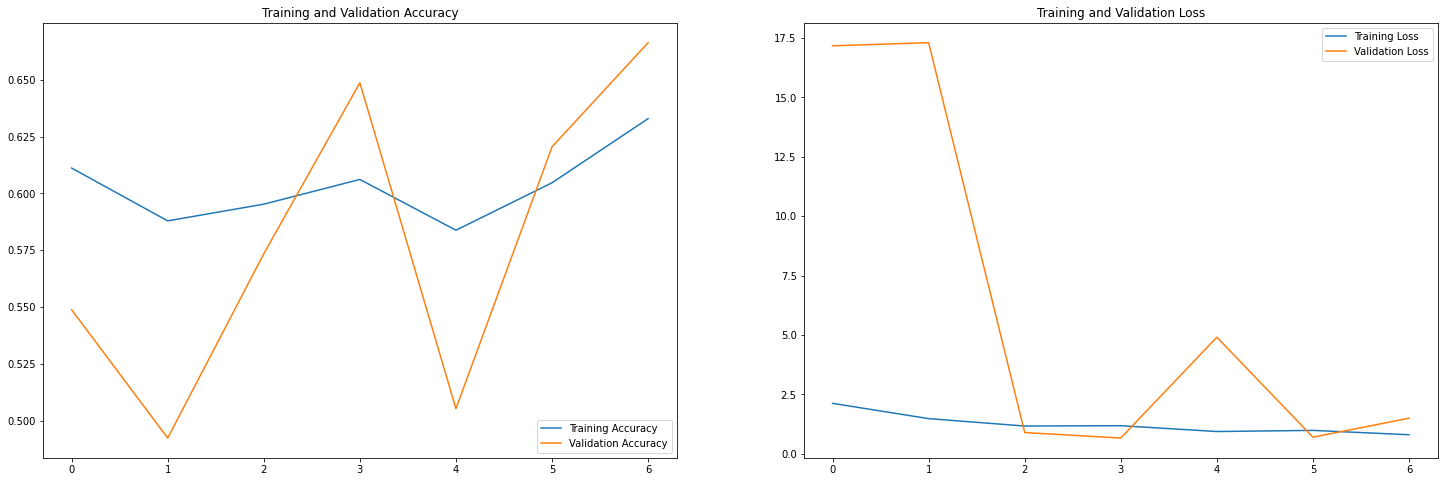

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)


#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')


plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
#plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')


plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluation

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_dataset, verbose=0)

#test_loss, test_acc = model.evaluate_generator(test_data_gen, verbose=0)

print('\nTest accuracy:', test_acc)



print('\nTest accuracy:', test_acc)

print('\nTest loss:', test_loss)













Instructions for updating:
Please use Model.evaluate, which supports generators.

Test accuracy: 0.6486486196517944

Test accuracy: 0.6486486196517944

Test loss: 0.6571130752563477


In [ ]:
## Make predictions on test data ##

### Let's make predictions on some images ###

test_generator.class_labels

predictions = model.predict_generator(test_dataset)

true_labels = test_generator.class_labels

predictions[0]

np.argmax(predictions[0])

test_generator.class_labels[0]

predictions[-1]

np.argmax(predictions[-1])

test_generator.class_labels[-1]



#test_dataset.classes

Instructions for updating:
Please use Model.predict, which supports generators.


1

In [ ]:
type(test_dataset)


tensorflow.python.data.ops.dataset_ops.FlatMapDataset

In [ ]:
#test_generator.image_paths

In [ ]:
test_generator.class_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[[542  25]
 [274  10]]


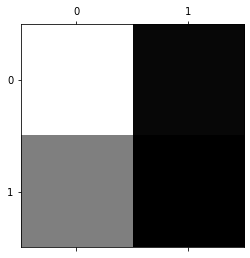

In [ ]:
## Confusion Matrix ##

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np



y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

y_pred





cm = confusion_matrix(y_true, y_pred)

print(cm)



plt.matshow(cm, cmap=plt.cm.gray)
plt.show()

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['damaged', 'undamaged']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     damaged       0.66      0.96      0.78       567
   undamaged       0.29      0.04      0.06       284

    accuracy                           0.65       851
   macro avg       0.47      0.50      0.42       851
weighted avg       0.54      0.65      0.54       851



## ROC-AUC ##

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print(roc_auc)

0.4955597784236282


In [ ]:
#train and evaluate model
#model.fit(train_dataset,epochs=10,verbose=1,workers=2,max_queue_size=20)